<a href="https://colab.research.google.com/github/AnastasiaBrinati/Progetto-ML-23-24/blob/main/task2_centralizzato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

# Regression: Predict gpus avg performance time in milliseconds.

In a *regression* problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

We are using the "SGEMM GPU kernel performance" dataset, which measures the running time of a matrix-matrix product A*B = C, where all matrices have size 2048 x 2048, using a parameterizable SGEMM GPU kernel with 241600 possible parameter combinations. For each tested combination, 4 runs were performed and their results are reported as the 4 last columns. All times are measured in milliseconds.
The results are then averaged and aggregated in one single final feature.
There are 14 parameter, the first 10 are ordinal and can only take up to 4 different powers of two values, and the 4 last variables are binary. Out of 1327104 total parameter combinations, only 241600 are feasible (due to various kernel constraints). This data set contains the results for all these feasible combinations.
The experiment was run on a desktop workstation running Ubuntu 16.04 Linux with an Intel Core i5 (3.5GHz), 16GB RAM, and a NVidia Geforce GTX 680 4GB GF580 GTX-1.5GB GPU. We use the 'gemm_fast' kernel from the automatic OpenCL kernel tuning library 'CLTune' (https://github.com/CNugteren/CLTune).
https://archive.ics.uci.edu/dataset/440/sgemm+gpu+kernel+performance

The models aim to predict the avg performance time.

#### Imports

In [16]:
# Use seaborn for pairplot.
!pip install datasets

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [18]:
import tensorflow as tf

from tensorflow import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping


print(tf.__version__)

2.15.0


In [19]:
!pip install -q -U keras-tuner

import keras_tuner as kt

### Get the data

In [20]:
from datasets import load_dataset
dataset = load_dataset("anastasiafrosted/gpus", download_mode="force_redownload")

Generating train split:   0%|          | 0/193280 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/48320 [00:00<?, ? examples/s]

### Split training from test

In [21]:
training_set = pd.DataFrame(dataset['train'])
columns = list(dataset['train'].features.keys())
training_set = training_set.drop("Unnamed: 0", axis=1)

test_set = pd.DataFrame(dataset['test'])
test_set = test_set.drop("Unnamed: 0", axis=1)

### Split features from labels

In [22]:
x_train = training_set.copy()
x_test = test_set.copy()

y_train = x_train.pop('avg_runs')
y_test = x_test.pop('avg_runs')

### Build the model

In [ ]:
def build_and_compile_model(hp):

  model = keras.Sequential()

  # Tune the number of units and activation function for each Dense layer
  for i in range(hp.Int('num_layers', 2, 4, default=3)):
    hp_units = hp.Int(f'units_{i}', min_value=16, max_value=128, step=16)
    hp_activation = hp.Choice(f'activation_{i}', values=['PReLU','LeakyReLU','relu', 'tanh', 'sigmoid'])

    model.add(layers.Dense(units=hp_units, activation=hp_activation, input_shape=(14,))) #, kernel_initializer=he_normal))

  # Output layer
  model.add(layers.Dense(1, activation='sigmoid')) #, kernel_initializer=glorot_normal))

  # Tune the learning rate for the optimizer
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=["mse", "mape", "mean_squared_logarithmic_error","logcosh", "R2Score"])
  return model

###Looking for hyperparameters

In [ ]:
tuner = kt.Hyperband(build_and_compile_model, objective='val_mse',max_epochs=10,factor=3,directory='my_dir',project_name='multi_layer_tuning')
stop = EarlyStopping(monitor='val_loss', patience=5)

tuner.search(x_train, y_train, epochs=10, validation_split=0.2, callbacks=[stop])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 02m 12s]
val_mse: 3.1347689628601074

Best val_mse So Far: 3.1206870079040527
Total elapsed time: 00h 33m 40s


In [ ]:
best_hps.values

{'num_layers': 2,
 'units_0': 128,
 'activation_0': 'sigmoid',
 'units_1': 128,
 'activation_1': 'sigmoid',
 'units_2': 112,
 'activation_2': 'PReLU',
 'learning_rate': 0.01,
 'units_3': 96,
 'activation_3': 'sigmoid',
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0012'}

In [ ]:
# Find the best epoch
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=10, validation_split=0.2)

val_acc_per_epoch = history.history['val_mse']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch:', best_epoch)

Epoch 1/10
4832/4832 [==============================] - 16s 3ms/step - loss: 0.7928 - mse: 3.8210 - mape: 94.9444 - mean_squared_logarithmic_error: 0.3139 - logcosh: 0.5342 - r2_score: 0.0225 - val_loss: 0.6574 - val_mse: 3.1533 - val_mape: 82.4749 - val_mean_squared_logarithmic_error: 0.1627 - val_logcosh: 0.4332 - val_r2_score: 0.1787
Epoch 2/10
4832/4832 [==============================] - 14s 3ms/step - loss: 0.6518 - mse: 3.2080 - mape: 80.6706 - mean_squared_logarithmic_error: 0.1603 - logcosh: 0.4353 - r2_score: 0.1794 - val_loss: 0.6359 - val_mse: 3.1347 - val_mape: 83.2983 - val_mean_squared_logarithmic_error: 0.1542 - val_logcosh: 0.4254 - val_r2_score: 0.1836
Epoch 3/10
4832/4832 [==============================] - 14s 3ms/step - loss: 0.6409 - mse: 3.1990 - mape: 78.9561 - mean_squared_logarithmic_error: 0.1562 - logcosh: 0.4315 - r2_score: 0.1817 - val_loss: 0.6378 - val_mse: 3.1372 - val_mape: 84.9477 - val_mean_squared_logarithmic_error: 0.1550 - val_logcosh: 0.4265 - val_

In [ ]:
tuned_model = tuner.hypermodel.build(best_hps)
tuned_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               1920      
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 18561 (72.50 KB)
Trainable params: 18561 (72.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Model

In [23]:
def get_model():

  model = keras.Sequential()

  # input layer
  model.add(layers.Dense(units=128, activation="sigmoid", input_shape=(14,)))

  # an hidden layer
  model.add(layers.Dense(units=128, activation="sigmoid"))

  # output layer
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=["mse", "mape", "mean_squared_logarithmic_error", "R2Score"])
  return model

In [25]:
dnn_model = get_model()
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               1920      
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 18561 (72.50 KB)
Trainable params: 18561 (72.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### History

In [26]:
%%time
history = dnn_model.fit(
    x_train,
    y_train,
    epochs=10,
    validation_split=0.2)


# non ho usato la best epoch perchè risulta essere la zero

Epoch 1/10
4832/4832 [==============================] - 20s 4ms/step - loss: 0.8628 - mse: 4.1653 - mape: 99.3090 - mean_squared_logarithmic_error: 0.3978 - r2_score: -0.0656 - val_loss: 0.6547 - val_mse: 3.1489 - val_mape: 84.4390 - val_mean_squared_logarithmic_error: 0.1583 - val_r2_score: 0.1799
Epoch 2/10
4832/4832 [==============================] - 14s 3ms/step - loss: 0.6473 - mse: 3.2023 - mape: 80.1259 - mean_squared_logarithmic_error: 0.1573 - r2_score: 0.1808 - val_loss: 0.6382 - val_mse: 3.1360 - val_mape: 79.7500 - val_mean_squared_logarithmic_error: 0.1546 - val_r2_score: 0.1832
Epoch 3/10
4832/4832 [==============================] - 13s 3ms/step - loss: 0.6405 - mse: 3.1988 - mape: 80.4783 - mean_squared_logarithmic_error: 0.1560 - r2_score: 0.1817 - val_loss: 0.6313 - val_mse: 3.1322 - val_mape: 77.7094 - val_mean_squared_logarithmic_error: 0.1526 - val_r2_score: 0.1842
Epoch 4/10
4832/4832 [==============================] - 13s 3ms/step - loss: 0.6308 - mse: 3.1902 - ma

In [27]:
results = dnn_model.evaluate(x_test, y_test)
print("[loss,mse,mape,mean_squared_logarithmic_error,r2_score]:", results)

1510/1510 [==============================] - 3s 2ms/step - loss: 0.6150 - mse: 3.1891 - mape: 77.7275 - mean_squared_logarithmic_error: 0.1485 - r2_score: 0.1847
[loss,mse,mape,mean_squared_logarithmic_error,r2_score]: [0.6149595379829407, 3.1890511512756348, 77.72752380371094, 0.1484648883342743, 0.1846550703048706]


In [37]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mse,mape,mean_squared_logarithmic_error,r2_score,val_loss,val_mse,val_mape,val_mean_squared_logarithmic_error,val_r2_score,epoch
0,0.862768,4.165329,99.308952,0.397793,-0.065561,0.654691,3.148931,84.439003,0.158293,0.179876,0
1,0.647280,3.202306,80.125908,0.157280,0.180798,0.638235,3.136050,79.750023,0.154645,0.183230,1
2,0.640516,3.198795,80.478287,0.156028,0.181695,0.631250,3.132224,77.709427,0.152647,0.184227,2
3,0.630772,3.190247,84.392601,0.151695,0.183882,0.620261,3.123100,80.765099,0.148184,0.186603,3
4,0.624861,3.187426,90.602760,0.150106,0.184605,0.620576,3.122755,93.155891,0.147896,0.186693,4
5,0.622176,3.186460,87.743385,0.149650,0.184851,0.616670,3.121987,78.399124,0.147527,0.186893,5
6,0.620396,3.185916,85.972107,0.149402,0.184990,0.613600,3.121242,78.342842,0.147210,0.187087,6
7,0.618982,3.185530,82.738770,0.149231,0.185088,0.613441,3.121131,79.306496,0.147167,0.187116,7
8,0.618057,3.185287,83.313438,0.149122,0.185151,0.611118,3.120584,76.801743,0.146897,0.187258,8
9,0.617114,3.185041,84.069107,0.148989,0.185215,0.611208,3.120517,77.030296,0.146838,0.187276,9


In [38]:
hist.columns

Index(['loss', 'mse', 'mape', 'mean_squared_logarithmic_error', 'r2_score',
       'val_loss', 'val_mse', 'val_mape', 'val_mean_squared_logarithmic_error',
       'val_r2_score', 'epoch'],
      dtype='object')

##Metrics insight


The mean of the distance from each point to the predicted regression model can be calculated, and shown as the **mean squared error**.
mean squared error has the disadvantage of heavily weighting outliers.
This is a result of the squaring of each term, which effectively weights large errors more heavily than small ones.

**Mean absolute error** (MAE) is a measure of errors between paired observations expressing the same phenomenon. MAE is calculated as the sum of absolute errors divided by the sample size.
The mean absolute error is one of a number of ways of comparing forecasts with their eventual outcomes. Well-established alternatives are the mean absolute scaled error (MASE) and the mean squared error.
MAE is not identical to root-mean square error (RMSE), although some researchers report and interpret it that way. The MAE is conceptually simpler and also easier to interpret than RMSE: it is simply the average absolute vertical or horizontal distance between each point in a scatter plot and the Y=X line. In other words, MAE is the average absolute difference between X and Y. Furthermore, each error contributes to MAE in proportion to the absolute value of the error. This is in contrast to RMSE which involves squaring the differences, so that a few large differences will increase the RMSE to a greater degree than the MAE.


The **Mean Squared Logarithmic Error (MSLE)** is a statistical measure used to evaluate the accuracy of a forecasting model, particularly when the data has a wide range of values. It measures the average of the squared differences between the logarithms of the predicted and actual values.
The logarithmic transformation used in the MSLE reduces the impact of large differences between the actual and predicted values and provides a better measure of the relative errors between the two values. The MSLE is always a positive value, with a smaller MSLE indicating better forecast accuracy.
The MSLE is commonly used in applications where the data has a wide range of
values and the relative errors are more important than the absolute errors.
It is important to note that the MSLE is not suitable for data with negative values or zero values, as the logarithm function is not defined for these values. + Best possible score is 0.0, smaller value is better. Range = [0, +inf)

**Logcosh** works mostly like the mean squared error, but will not be so strongly affected by the occasional wildly incorrect prediction.


In statistica, il **coefficiente di determinazione**, più comunemente **R2**, è un indice che misura il legame tra la variabilità dei dati e la correttezza del modello statistico utilizzato. Intuitivamente, esso è legato alla frazione della varianza non spiegata dal modello.

The **mean absolute percentage error (MAPE)**, also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method in statistics. It usually expresses the accuracy as a ratio
Mean absolute percentage error is commonly used as a loss function for regression problems and in model evaluation, because of its very intuitive interpretation in terms of relative error.
From a practical point of view, the use of the MAPE as a quality function for regression model is equivalent to doing weighted mean absolute error (MAE) regression, also known as quantile regression.
Although the concept of MAPE sounds very simple and convincing, it has major drawbacks in practical application, and there are many studies on shortcomings and misleading results from MAPE.(vedi wiki)

The result is a percentage indicating the average deviation of the predicted values from the actual values.


In statistics, the **mean absolute scaled error (MASE)** is a measure of the accuracy of forecasts. It is the mean absolute error of the forecast values, divided by the mean absolute error of the in-sample one-step naive forecast.
The mean absolute scaled error has favorable properties when compared to other methods for calculating forecast errors, such as root-mean-square-deviation, and is therefore recommended for determining comparative accuracy of forecasts.
The mean absolute scaled error can be easily interpreted, as values greater than one indicate that in-sample one-step forecasts from the naïve method perform better than the forecast values under consideration.

non presenti:

smape
mda
mad

In [30]:
dnn_model.metrics_names

['loss', 'mse', 'mape', 'mean_squared_logarithmic_error', 'r2_score']

In [35]:
from ctypes import alignment
def plot_loss(history):
  fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(19, 5))
  ax1.plot(history.history['loss'], label='loss (mae)')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax2.plot(history.history['mse'], label='mse')
  ax2.plot(history.history['val_mse'], label='val_mse')
  ax3.plot(history.history['mape'], label='mape')
  ax3.plot(history.history['val_mape'], label='val_mape')
  ax4.plot(history.history['mean_squared_logarithmic_error'], label='mean_squared_logarithmic_error')
  ax4.plot(history.history['val_mean_squared_logarithmic_error'], label='val_mean_squared_logarithmic_error')
  ax5.plot(history.history['r2_score'], label='r2_score')
  ax5.plot(history.history['val_r2_score'], label='val_r2_score')

  ax1.set(xlabel='Epoch', ylabel='loss (mae)')
  ax1.legend(loc="upper right")
  ax1.grid(True)

  ax2.set(xlabel='Epoch', ylabel='mse')
  ax2.legend(loc="upper right")
  ax2.grid(True)

  ax3.set(xlabel='Epoch', ylabel='mape')
  ax3.legend(loc="upper right")
  ax3.grid(True)

  ax4.set(xlabel='Epoch', ylabel='mean_squared_logarithmic_error')
  ax4.legend(loc="upper right")
  ax4.grid(True)

  ax5.set(xlabel='Epoch', ylabel='r2_score')
  ax5.legend(loc="upper right")
  ax5.grid(True)

  fig.tight_layout()

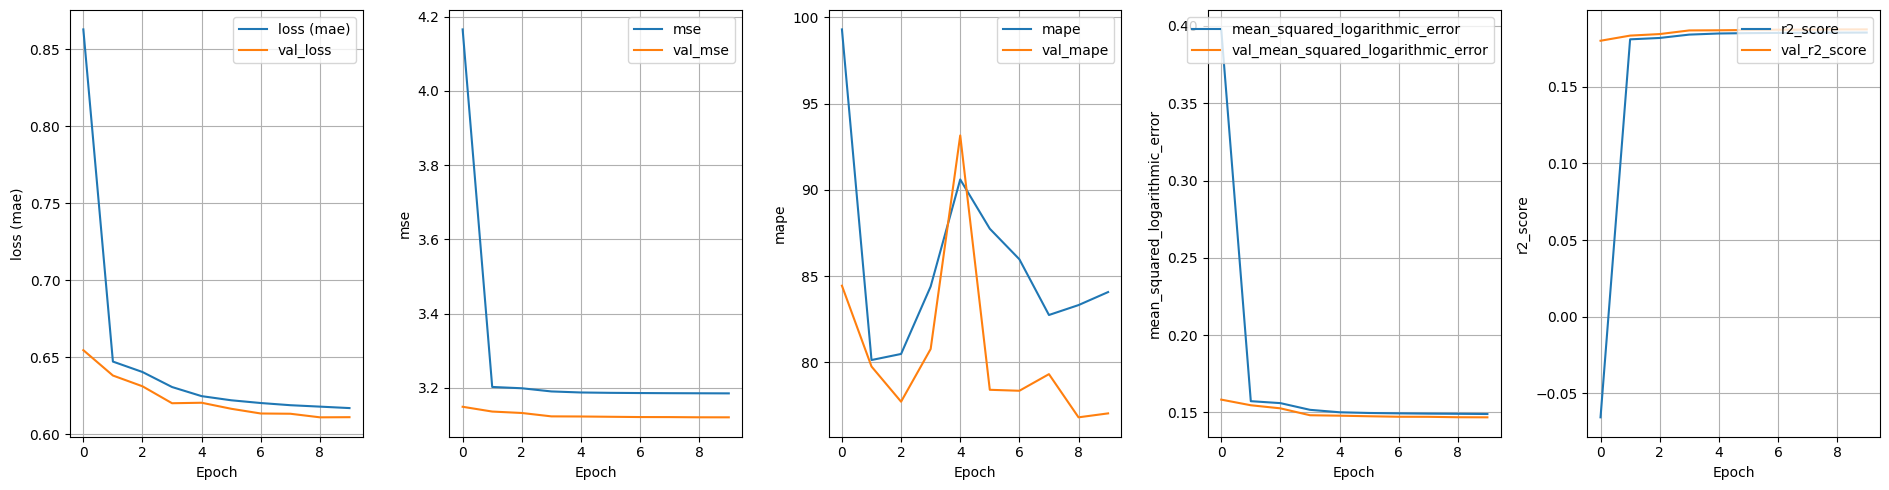

In [36]:
plot_loss(history)

Collect the results on the test set:

In [ ]:
loss,mse,mape,mean_squared_logarithmic_error,logcosh,r2_score = tuned_model.evaluate(x_test, y_test, verbose=0)

In [ ]:
test_results = {}

test_results['loss'] = loss
test_results['mse'] = mse
test_results['mean_squared_logarithmic_error'] = mean_squared_logarithmic_error
test_results['logcosh'] = logcosh
test_results['r2_score'] = r2_score

## Performance

Since all models have been trained, you can review their test set performance:

In [ ]:
pd.DataFrame(test_results, index=['loss',
 'mse',
 'mape',
 'mean_squared_logarithmic_error',
 'logcosh',
 'r2_score']).T

,loss,mse,mape,mean_squared_logarithmic_error,logcosh,r2_score
loss,0.609666,0.609666,0.609666,0.609666,0.609666,0.609666
mse,3.188002,3.188002,3.188002,3.188002,3.188002,3.188002
mean_squared_logarithmic_error,0.147992,0.147992,0.147992,0.147992,0.147992,0.147992
logcosh,0.423757,0.423757,0.423757,0.423757,0.423757,0.423757
r2_score,0.184923,0.184923,0.184923,0.184923,0.184923,0.184923


These results match the validation error observed during training.

### Make predictions

You can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss:

1510/1510 [==============================] - 2s 1ms/step


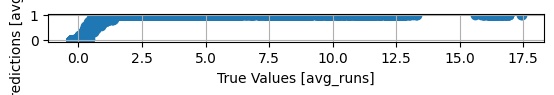

In [ ]:
test_predictions = tuned_model.predict(x_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [avg_runs]')
plt.ylabel('Predictions [avg_runs]')
plt.grid(True)

In [ ]:
r = tuned_model.predict(x_test)
r

1510/1510 [==============================] - 3s 2ms/step


array([[0.016],
       [1.   ],
       [0.   ],
       ...,
       [1.   ],
       [0.   ],
       [0.   ]], dtype=float32)

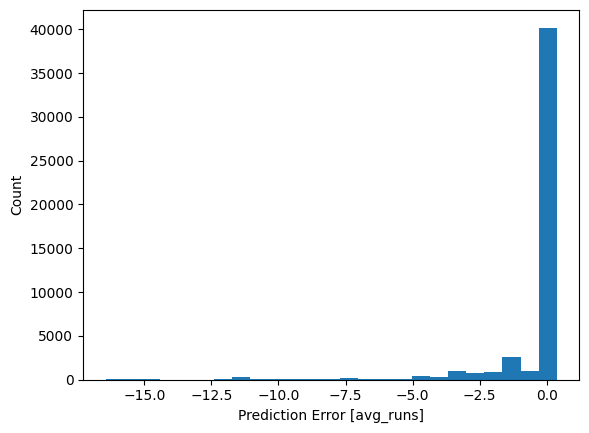

In [ ]:
error = test_predictions - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [avg_runs]')
_ = plt.ylabel('Count')

If you're happy with the model, save it for later use with `Model.save`:

In [ ]:
tuned_model.save('dnn_model.keras')

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [avg_runs]']).T

,Mean absolute error [avg_runs]
loss,0.609666
mse,3.188002
mean_squared_logarithmic_error,0.147992
logcosh,0.423757
r2_score,0.184923


## Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

- Mean squared error (MSE) (`tf.keras.losses.MeanSquaredError`) and mean absolute error (MAE) (`tf.keras.losses.MeanAbsoluteError`) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.
- Similarly, evaluation metrics used for regression differ from classification.
- When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
- Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the [Overfit and underfit](overfit_and_underfit.ipynb) tutorial for more help with this.